In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/Hopefully ICML"

/content/drive/My Drive/Colab Notebooks/Hopefully ICML


In [ ]:
%%capture
!pip install shap
!pip install pytorch_lightning -qq
!pip install --upgrade wandb -qq
!pip install loguru
!pip install ray

# Install Pacakges

In [ ]:
import pandas as pd
import numpy as np
from SHAM.data import ProcessData
from SHAM.mlp_model import MLP
from SHAM.sham import SHAM
from SHAM import utils
from nam.config import defaults

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)

In [ ]:
file = pd.read_csv('evo_data.csv')
get_data = ProcessData()

In [ ]:
file = file.rename(columns={'Gender': 'Sex'})
file.head()

,ID,SoundClass,hProg,hVol,LonRel,LatRel,Timestamp,PTA4,Sex,Age
0,31,Speech,Medium,-1.0,-0.359245,0.024797,20/04/2018 15:24,37.50,F,73
1,1,Speech,Medium,-5.0,2.806775,1.368971,01/03/2018 17:41,36.25,F,70
2,11,Quiet,Medium,0.0,-0.412954,0.048672,14/04/2018 16:05,40.00,M,70
3,34,Speech,Medium,0.0,0.647073,-0.194338,28/04/2018 14:42,13.75,F,79
4,23,Quiet,Medium,0.0,-1.467754,-0.943349,14/03/2018 13:48,0.00,F,77


# Setting Up Data Pre-processing

In [ ]:
ids = 'ID'
date = 'Timestamp'
ordinal_col = ['SoundClass', 'hProg']
nominal_col = ['Sex']
cont_col = ['Age', 'hVol', 'LonRel', 'LatRel', 'PTA4', 'Usage']

compute_usage is only applicable to EvoSynth dataset paper, however, it can be applied to any dataset that needs calculating the difference between timestamps

In [ ]:
processed_data = get_data.get_processed_data(file,
                                             ids,
                                             date,
                                             ordinal_col,
                                             nominal_col,
                                             groupby='ID',
                                             compute_usage=True,
                                             aggregate_variables=True,
                                             impute_days=True,
                                             remove_outliers=True,
                                             weekday=False)

In [ ]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12495 entries, 1 to 13037
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ID          12495 non-null  float64       
 1   hVol        12495 non-null  float64       
 2   LonRel      12495 non-null  float64       
 3   LatRel      12495 non-null  float64       
 4   PTA4        12495 non-null  float64       
 5   Age         12495 non-null  float64       
 6   Usage       12495 non-null  float64       
 7   SoundClass  12495 non-null  float64       
 8   hProg       12495 non-null  float64       
 9   Sex_1       12495 non-null  float64       
 10  Sex_2       12495 non-null  float64       
 11  Date        12495 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.2 MB


In [ ]:
static_cols = processed_data[['ID', 'Age', 'Sex_1', 'Sex_2', 'Date']]
static_cols_lens = len(static_cols.columns)

In [ ]:
original_data = get_data.transform_variables(processed_data,
                                             ids,
                                             ordinal_col,
                                             nominal_col,
                                             cont_col,
                                             outcome='Usage',
                                             transformed=False,
                                             return_scaler=False)

In [ ]:
transformed_data = get_data.transform_variables(processed_data,
                                                ids,
                                                ordinal_col,
                                                nominal_col,
                                                cont_col,
                                                outcome='Usage',
                                                transformed=True,
                                                return_scaler=False)

In [ ]:
scaler, normaliser = get_data.transform_variables(processed_data,
                                                  ids,
                                                  ordinal_col,
                                                  nominal_col,
                                                  cont_col,
                                                  outcome='Usage',
                                                  transformed=True,
                                                  return_scaler=True)

In [ ]:
data = get_data.preprocess_timesteps(original_data,
                                     static_cols_lens=static_cols_lens,
                                     n_in=1,
                                     n_out=1,
                                     groupby='ID',
                                     dropnan=True)

data.head()

,ID,Date,Sex_1,Sex_2,SoundClass,hProg,Age,hVol,LonRel,LatRel,PTA4,Usage,Outcome
0,27.0,2018-01-03,0.0,1.0,1.554398,2.118774,74.0,0.276939,-0.084114,-0.114698,53.75,810.000000,37080.000000
1,27.0,2018-01-05,0.0,1.0,1.348315,1.762172,74.0,0.469008,-0.211074,-0.015127,53.75,37080.000000,37163.225806
2,27.0,2018-01-06,0.0,1.0,1.554398,2.118774,74.0,0.276939,-0.084114,-0.114698,53.75,37163.225806,37246.451613
3,27.0,2018-01-07,0.0,1.0,1.554398,2.118774,74.0,0.276939,-0.084114,-0.114698,53.75,37246.451613,37329.677419
4,27.0,2018-01-08,0.0,1.0,1.554398,2.118774,74.0,0.276939,-0.084114,-0.114698,53.75,37329.677419,37412.903226


In [ ]:
trans_data = get_data.preprocess_timesteps(transformed_data,
                                           static_cols_lens=static_cols_lens,
                                           n_in=1,
                                           n_out=1,
                                           groupby='ID',
                                           dropnan=True)

trans_data.head()

,ID,Date,Sex_1,Sex_2,SoundClass,hProg,Age,hVol,LonRel,LatRel,PTA4,Usage,Outcome
0,27.0,2018-01-03,0.0,1.0,0.696799,0.706258,0.583333,0.804715,0.707615,0.696315,0.781818,0.010823,0.534226
1,27.0,2018-01-05,0.0,1.0,0.604417,0.587391,0.583333,0.822325,0.686226,0.727040,0.781818,0.534226,0.535427
2,27.0,2018-01-06,0.0,1.0,0.696799,0.706258,0.583333,0.804715,0.707615,0.696315,0.781818,0.535427,0.536628
3,27.0,2018-01-07,0.0,1.0,0.696799,0.706258,0.583333,0.804715,0.707615,0.696315,0.781818,0.536628,0.537829
4,27.0,2018-01-08,0.0,1.0,0.696799,0.706258,0.583333,0.804715,0.707615,0.696315,0.781818,0.537829,0.539030


# Spiltting the Data

In [ ]:
train_data = get_data.split_dataset_per_user(data,
                                            regression=True,
                                            return_train_data=True,
                                            return_with_ids=False)

In [ ]:
trainX_ids, _, testX_ids, \
trainY_ids, valY_ids, testY_ids = \
    get_data.split_dataset_per_user(data,
                                   regression=True,
                                   return_train_data=False,
                                   return_with_ids=True)

In [ ]:
trans_trainX_ids, trans_valX_ids, trans_testX_ids, \
trans_trainY_ids, trans_valY_ids, trans_testY_ids = get_data.split_dataset_per_user(trans_data,
                                                                                    regression=True,
                                                                                    return_train_data=False,
                                                                                    return_with_ids=True)

In [ ]:
trans_trainX, trans_valX, trans_testX, \
trans_trainY, trans_valY, trans_testY = \
    get_data.split_dataset_per_user(trans_data,
                                    regression=True,
                                    return_train_data=False,
                                    return_with_ids=False)

In [ ]:
trainX, valX, testX, \
trainY, valY, testY = get_data.split_dataset_per_user(data,
                                                      regression=True,
                                                      return_train_data=False,
                                                      return_with_ids=False)

In [ ]:
feature_names = list(data.columns)
feature_names.remove('ID')
feature_names.remove('Date')
feature_names.remove('Outcome')

# Setting Up the MLP

In [ ]:
model = MLP(title='EvoSynth_SHAP',
            epochs=200, 
            directory='tuner/evotion_synth/run',
            regression=True)

In [ ]:
bm_path = model.train_model(trans_trainX,
                            trans_valX,
                            trans_trainY,
                            trans_valY,
                            verbose=1,
                            name='v1')

Num GPUs Available:  0
Epoch 1/200
5/5 [==============================] - 1s 92ms/step - loss: 0.1610 - mse: 0.1610 - rmse: 0.4012 - mae: 0.3027 - mape: 449983.2188 - val_loss: 0.1583 - val_mse: 0.1583 - val_rmse: 0.3979 - val_mae: 0.2931 - val_mape: 483492.2812
Epoch 2/200
5/5 [==============================] - 0s 31ms/step - loss: 0.1342 - mse: 0.1342 - rmse: 0.3663 - mae: 0.2646 - mape: 370326.0938 - val_loss: 0.1357 - val_mse: 0.1357 - val_rmse: 0.3684 - val_mae: 0.2580 - val_mape: 975331.3125
Epoch 3/200
5/5 [==============================] - 0s 28ms/step - loss: 0.1152 - mse: 0.1152 - rmse: 0.3394 - mae: 0.2364 - mape: 414789.8438 - val_loss: 0.1204 - val_mse: 0.1204 - val_rmse: 0.3469 - val_mae: 0.2391 - val_mape: 1409739.5000
Epoch 4/200
5/5 [==============================] - 0s 27ms/step - loss: 0.1038 - mse: 0.1038 - rmse: 0.3222 - mae: 0.2215 - mape: 416212.6562 - val_loss: 0.1126 - val_mse: 0.1126 - val_rmse: 0.3356 - val_mae: 0.2314 - val_mape: 1533975.6250
Epoch 5/200
5/5

In [ ]:
prediction = model.predict(trans_testX,
                           trans_testX_ids,
                           scaler,
                           normaliser,
                           saved_model_path=bm_path)

78/78 [==============================] - 0s 1ms/step


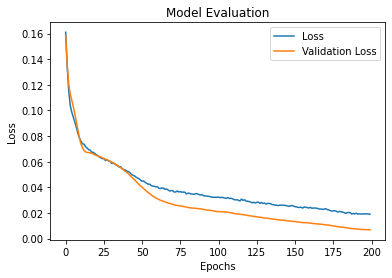

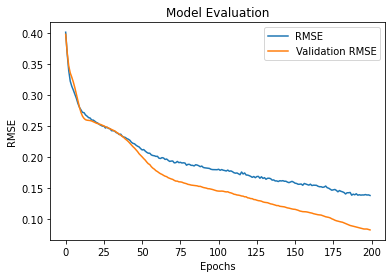

In [ ]:
model.plot_loss_regression()

# Getting the SHAP Values from the MLP

  0%|          | 0/2485 [00:00<?, ?it/s]

  0%|          | 0/9957 [00:00<?, ?it/s]

  0%|          | 0/1993 [00:00<?, ?it/s]

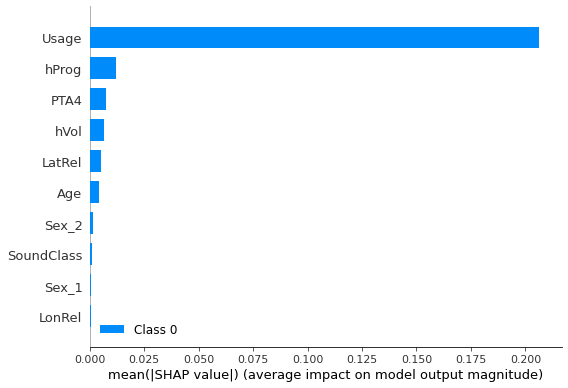

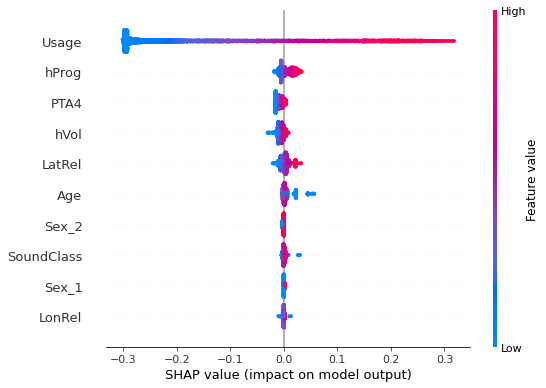

In [ ]:
shap_df = model.get_SHAPValues(trans_trainX_ids,
                               trans_trainY_ids,
                               trans_testX_ids,
                               trans_testY_ids,
                               trans_valX_ids, 
                               trans_valY_ids,
                               feature_names,
                               saved_model_path=bm_path)

# Setting Up NAM

In [ ]:
config = defaults()
config.num_epochs = 100
config.regression = True
config.use_dnn = True
config.fold_num = 2
print(config)

Config(activation='exu', batch_size=128, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.1, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.1, fold_num=2, hidden_sizes=[], l2_regularization=0.1, logdir='output', lr=0.01, num_basis_functions=1000, num_epochs=100, num_folds=5, num_models=1, num_splits=3, num_workers=16, output_regularization=0.1, regression=True, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=True, wandb=False)


## Training

In [ ]:
Baseline_EvoSynth = SHAM(
    datapath=trans_data,
    abs_datapath=trans_data,
    shap_datapath=shap_df,
    abs_shap_datapath=shap_df,
    dataset_name='EvoSynth',
    mode='Baseline',
    hyper_tuning=False,
    config = config
)

In [ ]:
Baseline_EvoSynth.run()

2023-01-25 19:21:29.840 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[1]: train: 7258, val: 1037
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 12.2 K
-------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-01-25 19:23:40.486 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[2]: train: 7258, val: 1037
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 12.2 K
-------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-01-25 19:23:44.014 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[3]: train: 7258, val: 1037
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 12.2 K
-------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-01-25 19:23:47.579 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[4]: train: 7258, val: 1037
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 12.2 K
-------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-01-25 19:23:51.177 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[5]: train: 7258, val: 1037
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 12.2 K
-------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

-----------------------------------
Finish training with 3.6740288734436035s


In [ ]:
SHAP_EvoSynth = SHAM(
    datapath=trans_data,
    abs_datapath=trans_data,
    shap_datapath=shap_df,
    abs_shap_datapath=shap_df,
    dataset_name='EvoSynth',
    mode='SHAP',
    hyper_tuning=False,
    config = config
)

In [ ]:
SHAP_EvoSynth.run()

2023-01-25 19:23:55.527 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[1]: train: 7234, val: 1034
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 20.0 K
-------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-01-25 19:26:20.218 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[2]: train: 7234, val: 1034
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 20.0 K
-------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-01-25 19:26:24.234 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[3]: train: 7234, val: 1034
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 20.0 K
-------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-01-25 19:26:28.204 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[4]: train: 7234, val: 1034
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 20.0 K
-------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-01-25 19:26:32.116 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[5]: train: 7234, val: 1034
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 20.0 K
-------------------------------
20.0 K    Trainable params
0         Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

-----------------------------------
Finish training with 3.8894546031951904s


In [ ]:
Weighted_EvoSynth = SHAM(
    datapath=trans_data,
    abs_datapath=trans_data,
    shap_datapath=shap_df,
    abs_shap_datapath=shap_df,
    dataset_name='EvoSynth',
    mode='Weighted',
    hyper_tuning=False,
    config = config
)

In [ ]:
Weighted_EvoSynth.run()

2023-01-25 19:19:36.345 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[1]: train: 7234, val: 1034
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 12.2 K
-------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-01-25 19:21:15.105 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[2]: train: 7234, val: 1034
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 12.2 K
-------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-01-25 19:21:18.566 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[3]: train: 7234, val: 1034
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 12.2 K
-------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-01-25 19:21:21.959 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[4]: train: 7234, val: 1034
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 12.2 K
-------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

2023-01-25 19:21:25.463 | INFO     | nam.data.folded:train_dataloaders:80 - Fold[5]: train: 7234, val: 1034
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 12.2 K
-------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

-----------------------------------
Finish training with 3.701726198196411s


## Testing

In [ ]:
Baseline_EvoSynth.test_models()

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    MAE_metric_epoch        0.5778865814208984
     test_loss_epoch        0.46414366364479065
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
SHAP_EvoSynth.test_models()

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    MAE_metric_epoch        0.8569497466087341
     test_loss_epoch        0.9717926383018494
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
Weighted_EvoSynth.test_models()

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    MAE_metric_epoch        0.17541557550430298
     test_loss_epoch        0.11018641293048859
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Predicting

Predicting: 57it [00:00, ?it/s]

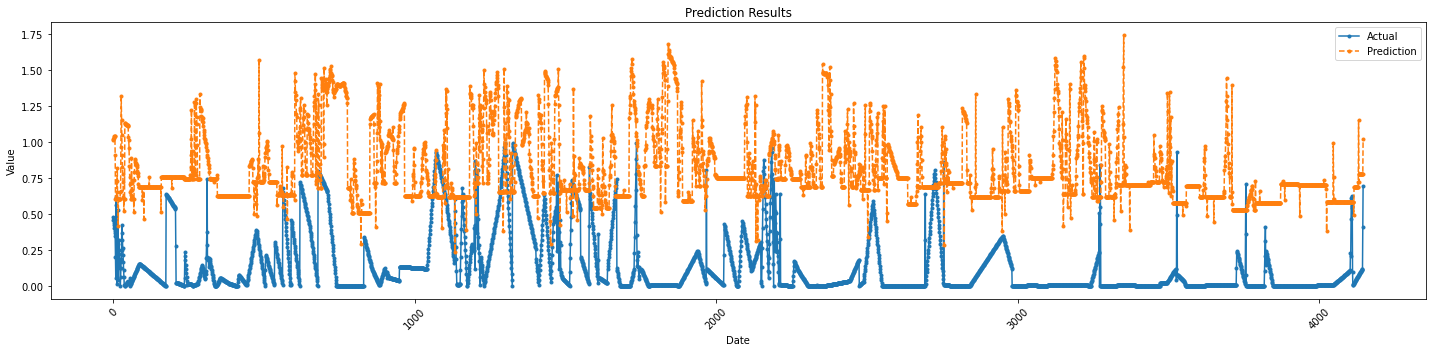

-----------------------------
sMAPE is: 1.5070188735840246
MASE is: 36.013921027061954
MAPE is: inf
-----------------------------


In [ ]:
Baseline_EvoSynth.plot_predictions(error_estimators=True)

Predicting: 57it [00:00, ?it/s]

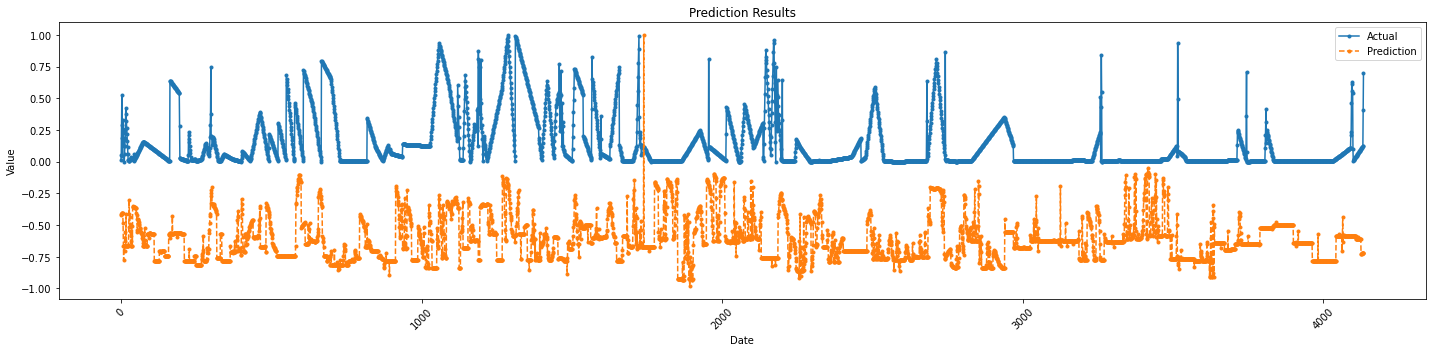

-----------------------------
sMAPE is: 1.9998979584322292
MASE is: 41.14819513453986
MAPE is: inf
-----------------------------


In [ ]:
SHAP_EvoSynth.plot_predictions(error_estimators=True)

Predicting: 57it [00:00, ?it/s]

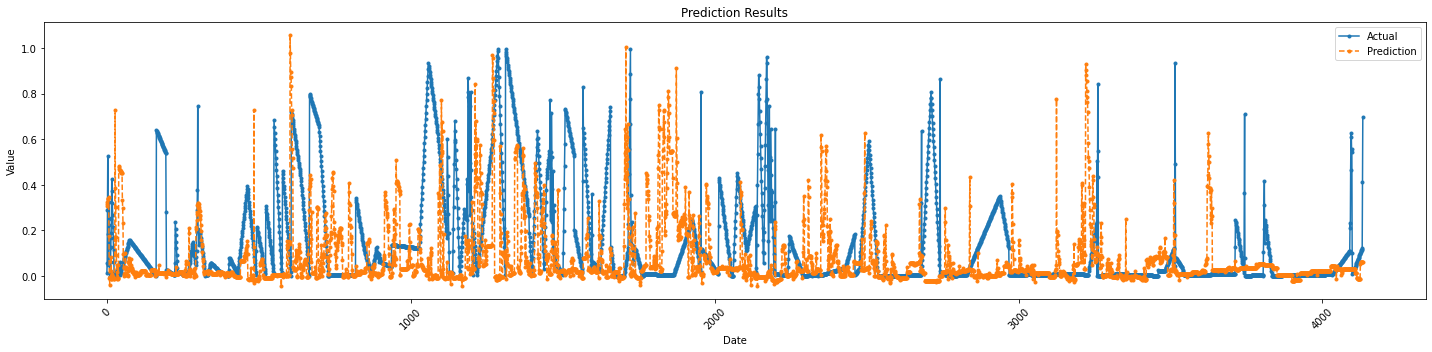

-----------------------------
sMAPE is: 1.382201718519922
MASE is: 8.536990792446144
MAPE is: inf
-----------------------------


In [ ]:
Weighted_EvoSynth.plot_predictions(error_estimators=True)

# Visualisation

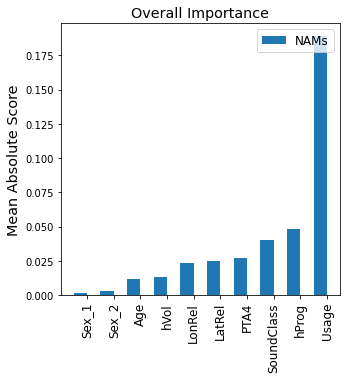

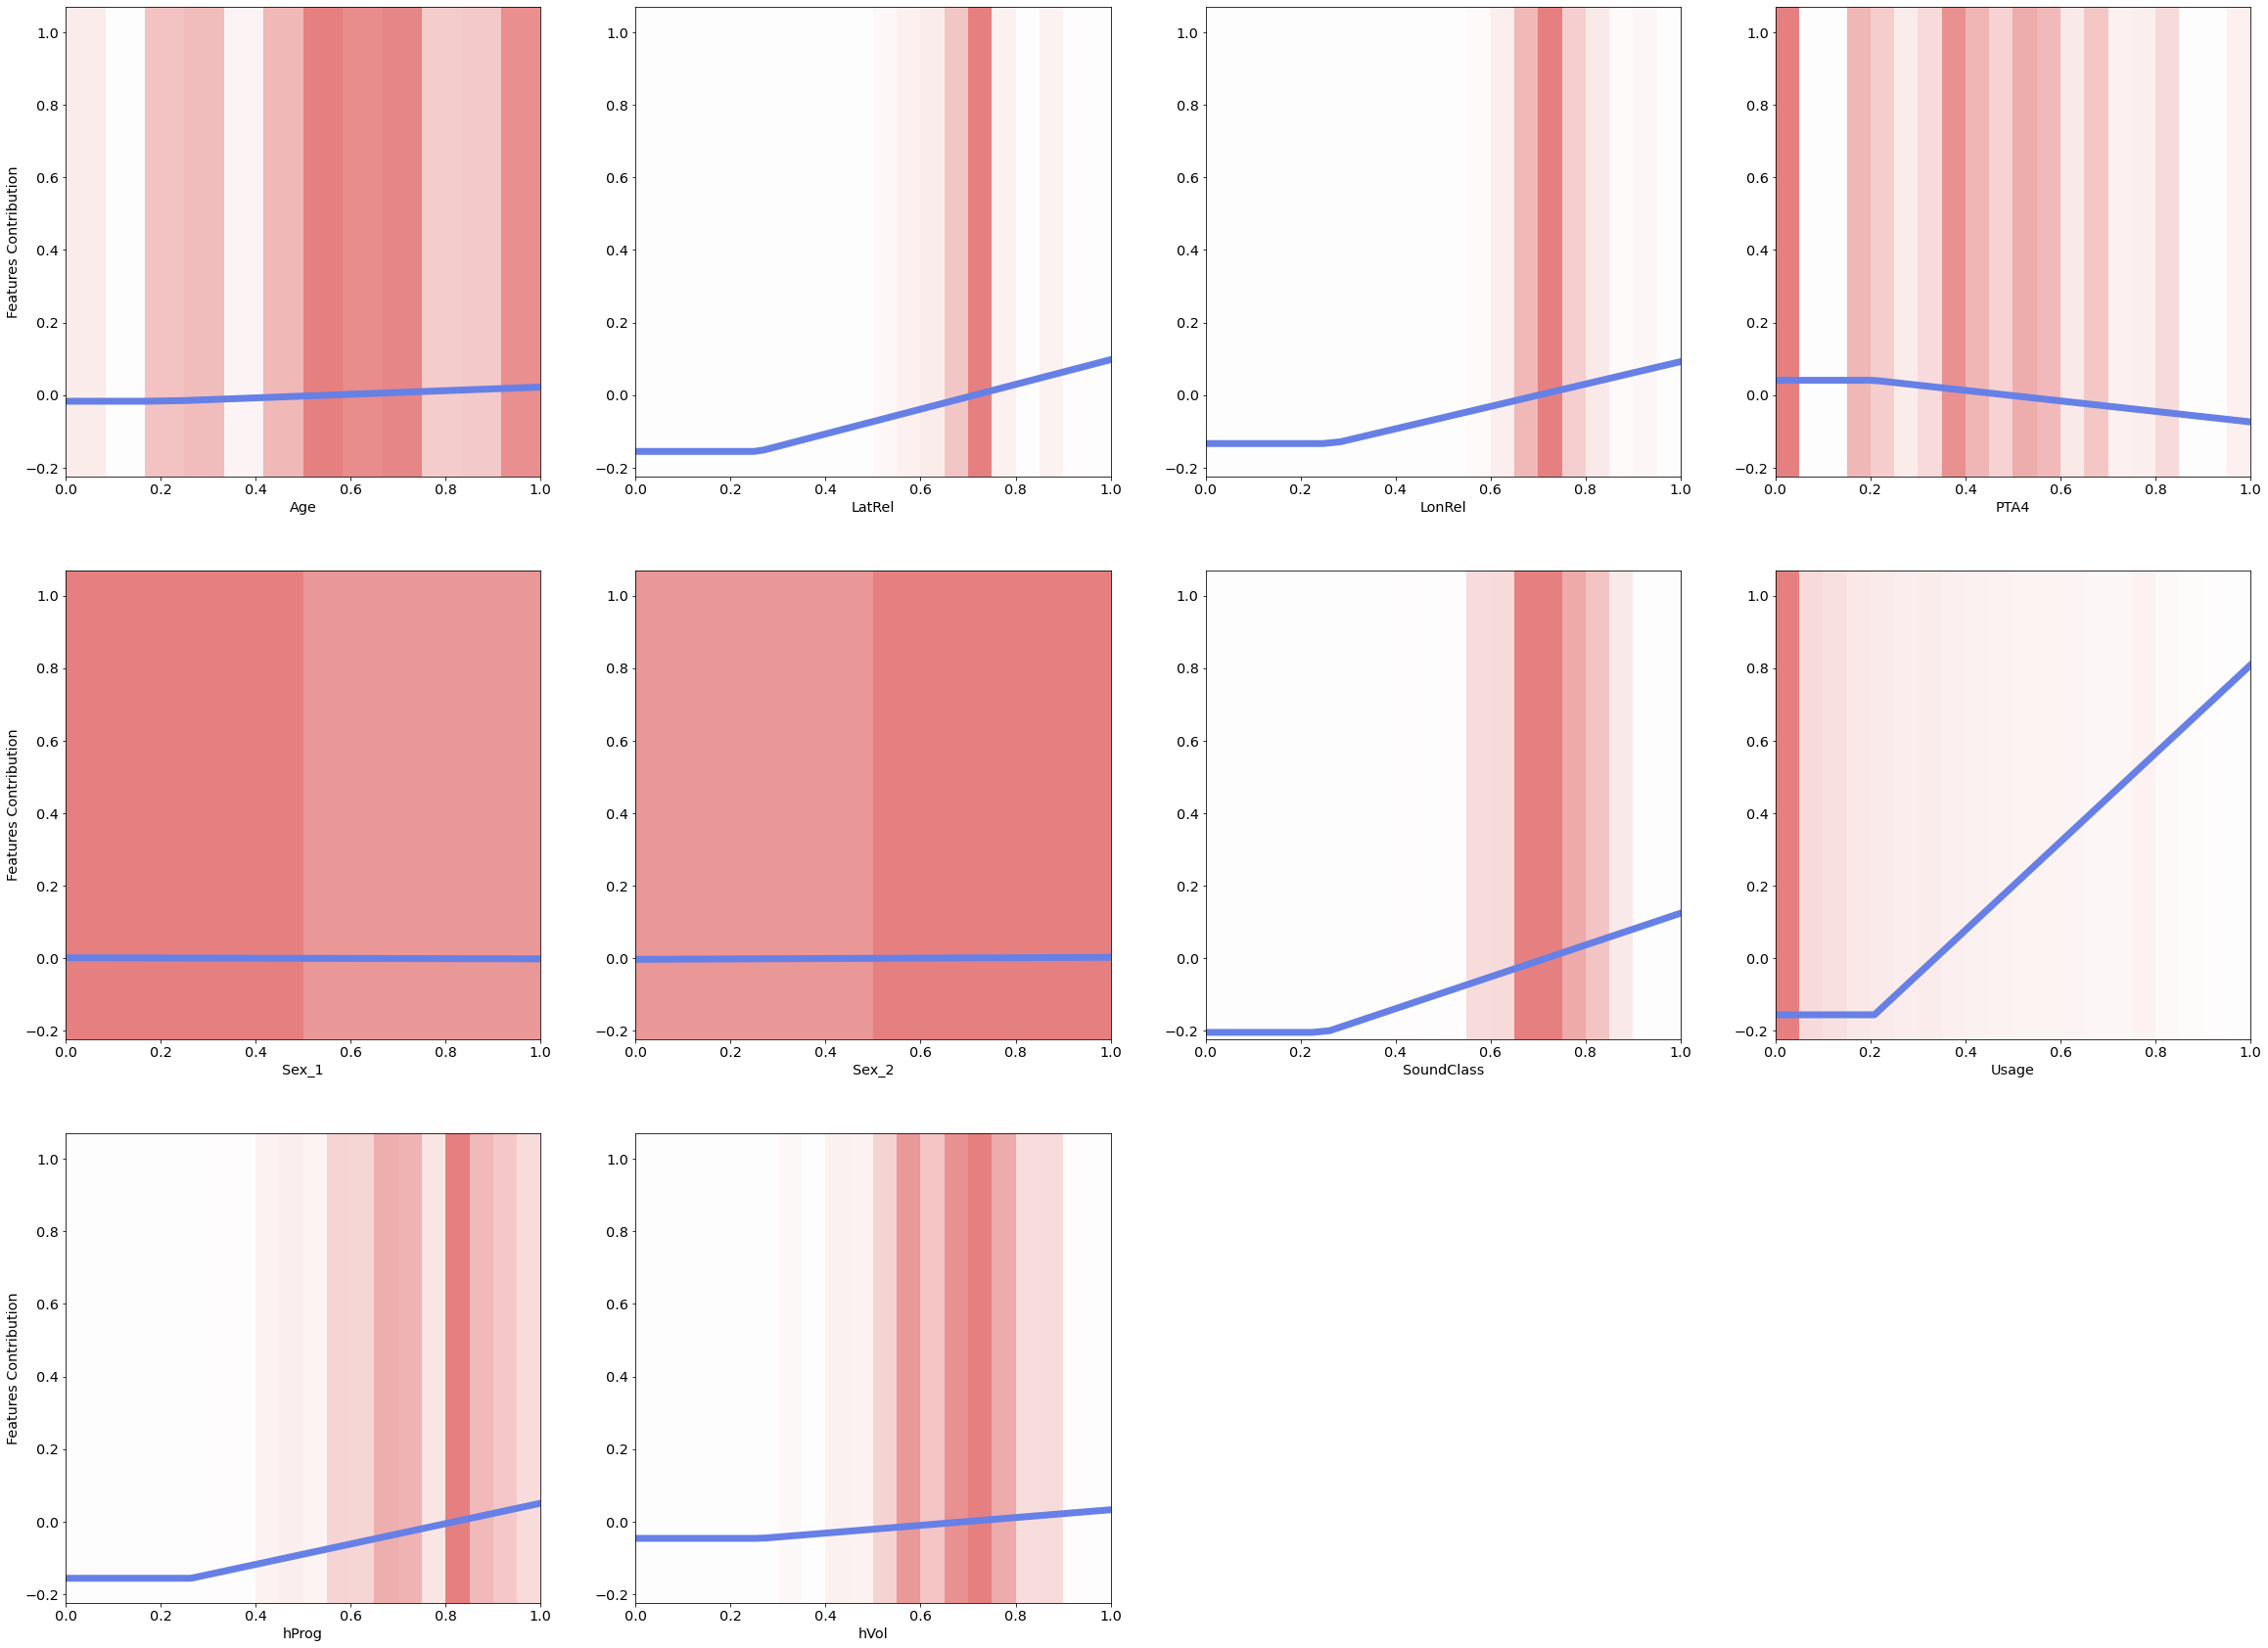

In [ ]:
Baseline_EvoSynth.visualisation()

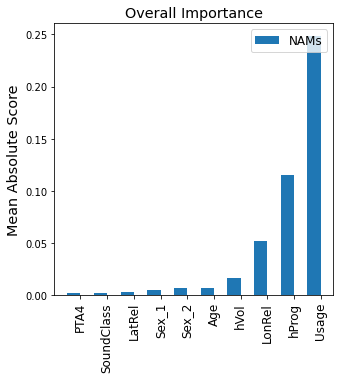

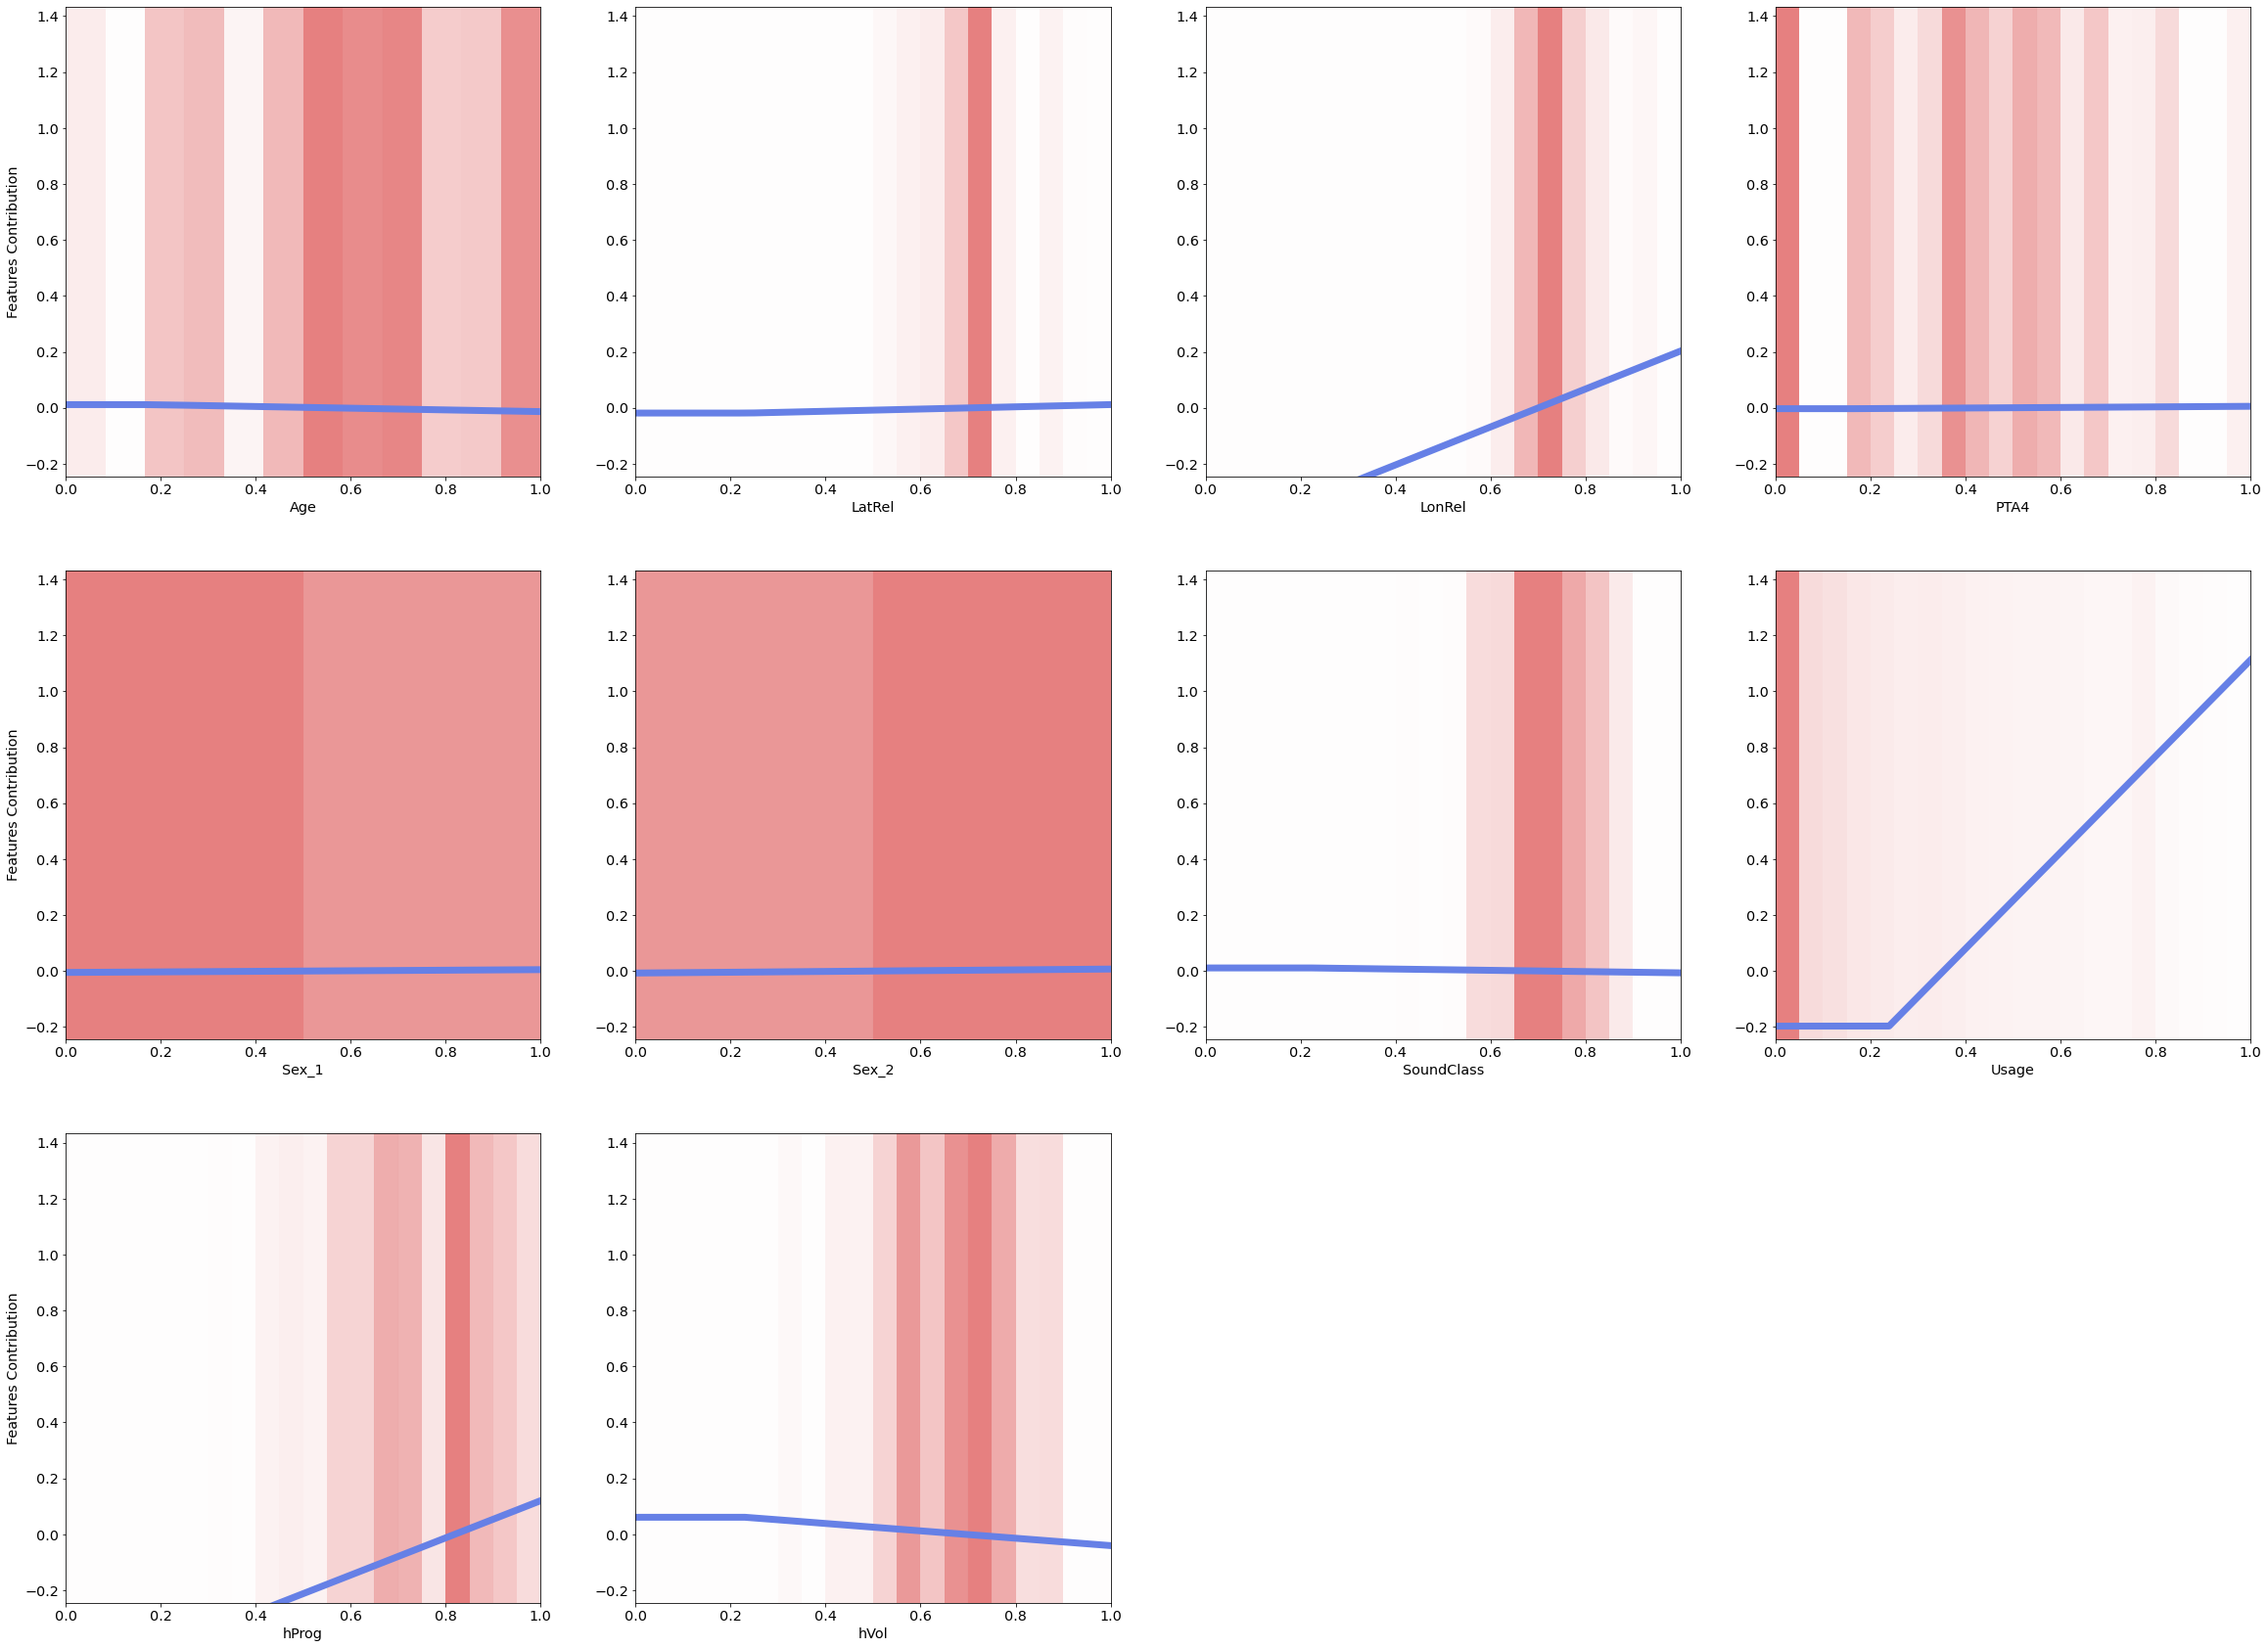

In [ ]:
Weighted_EvoSynth.visualisation()

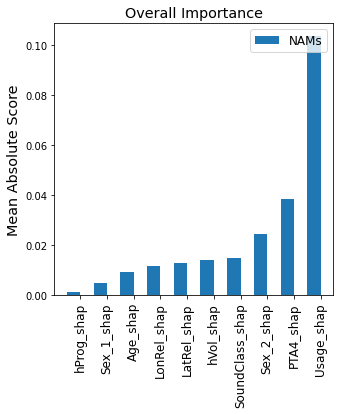

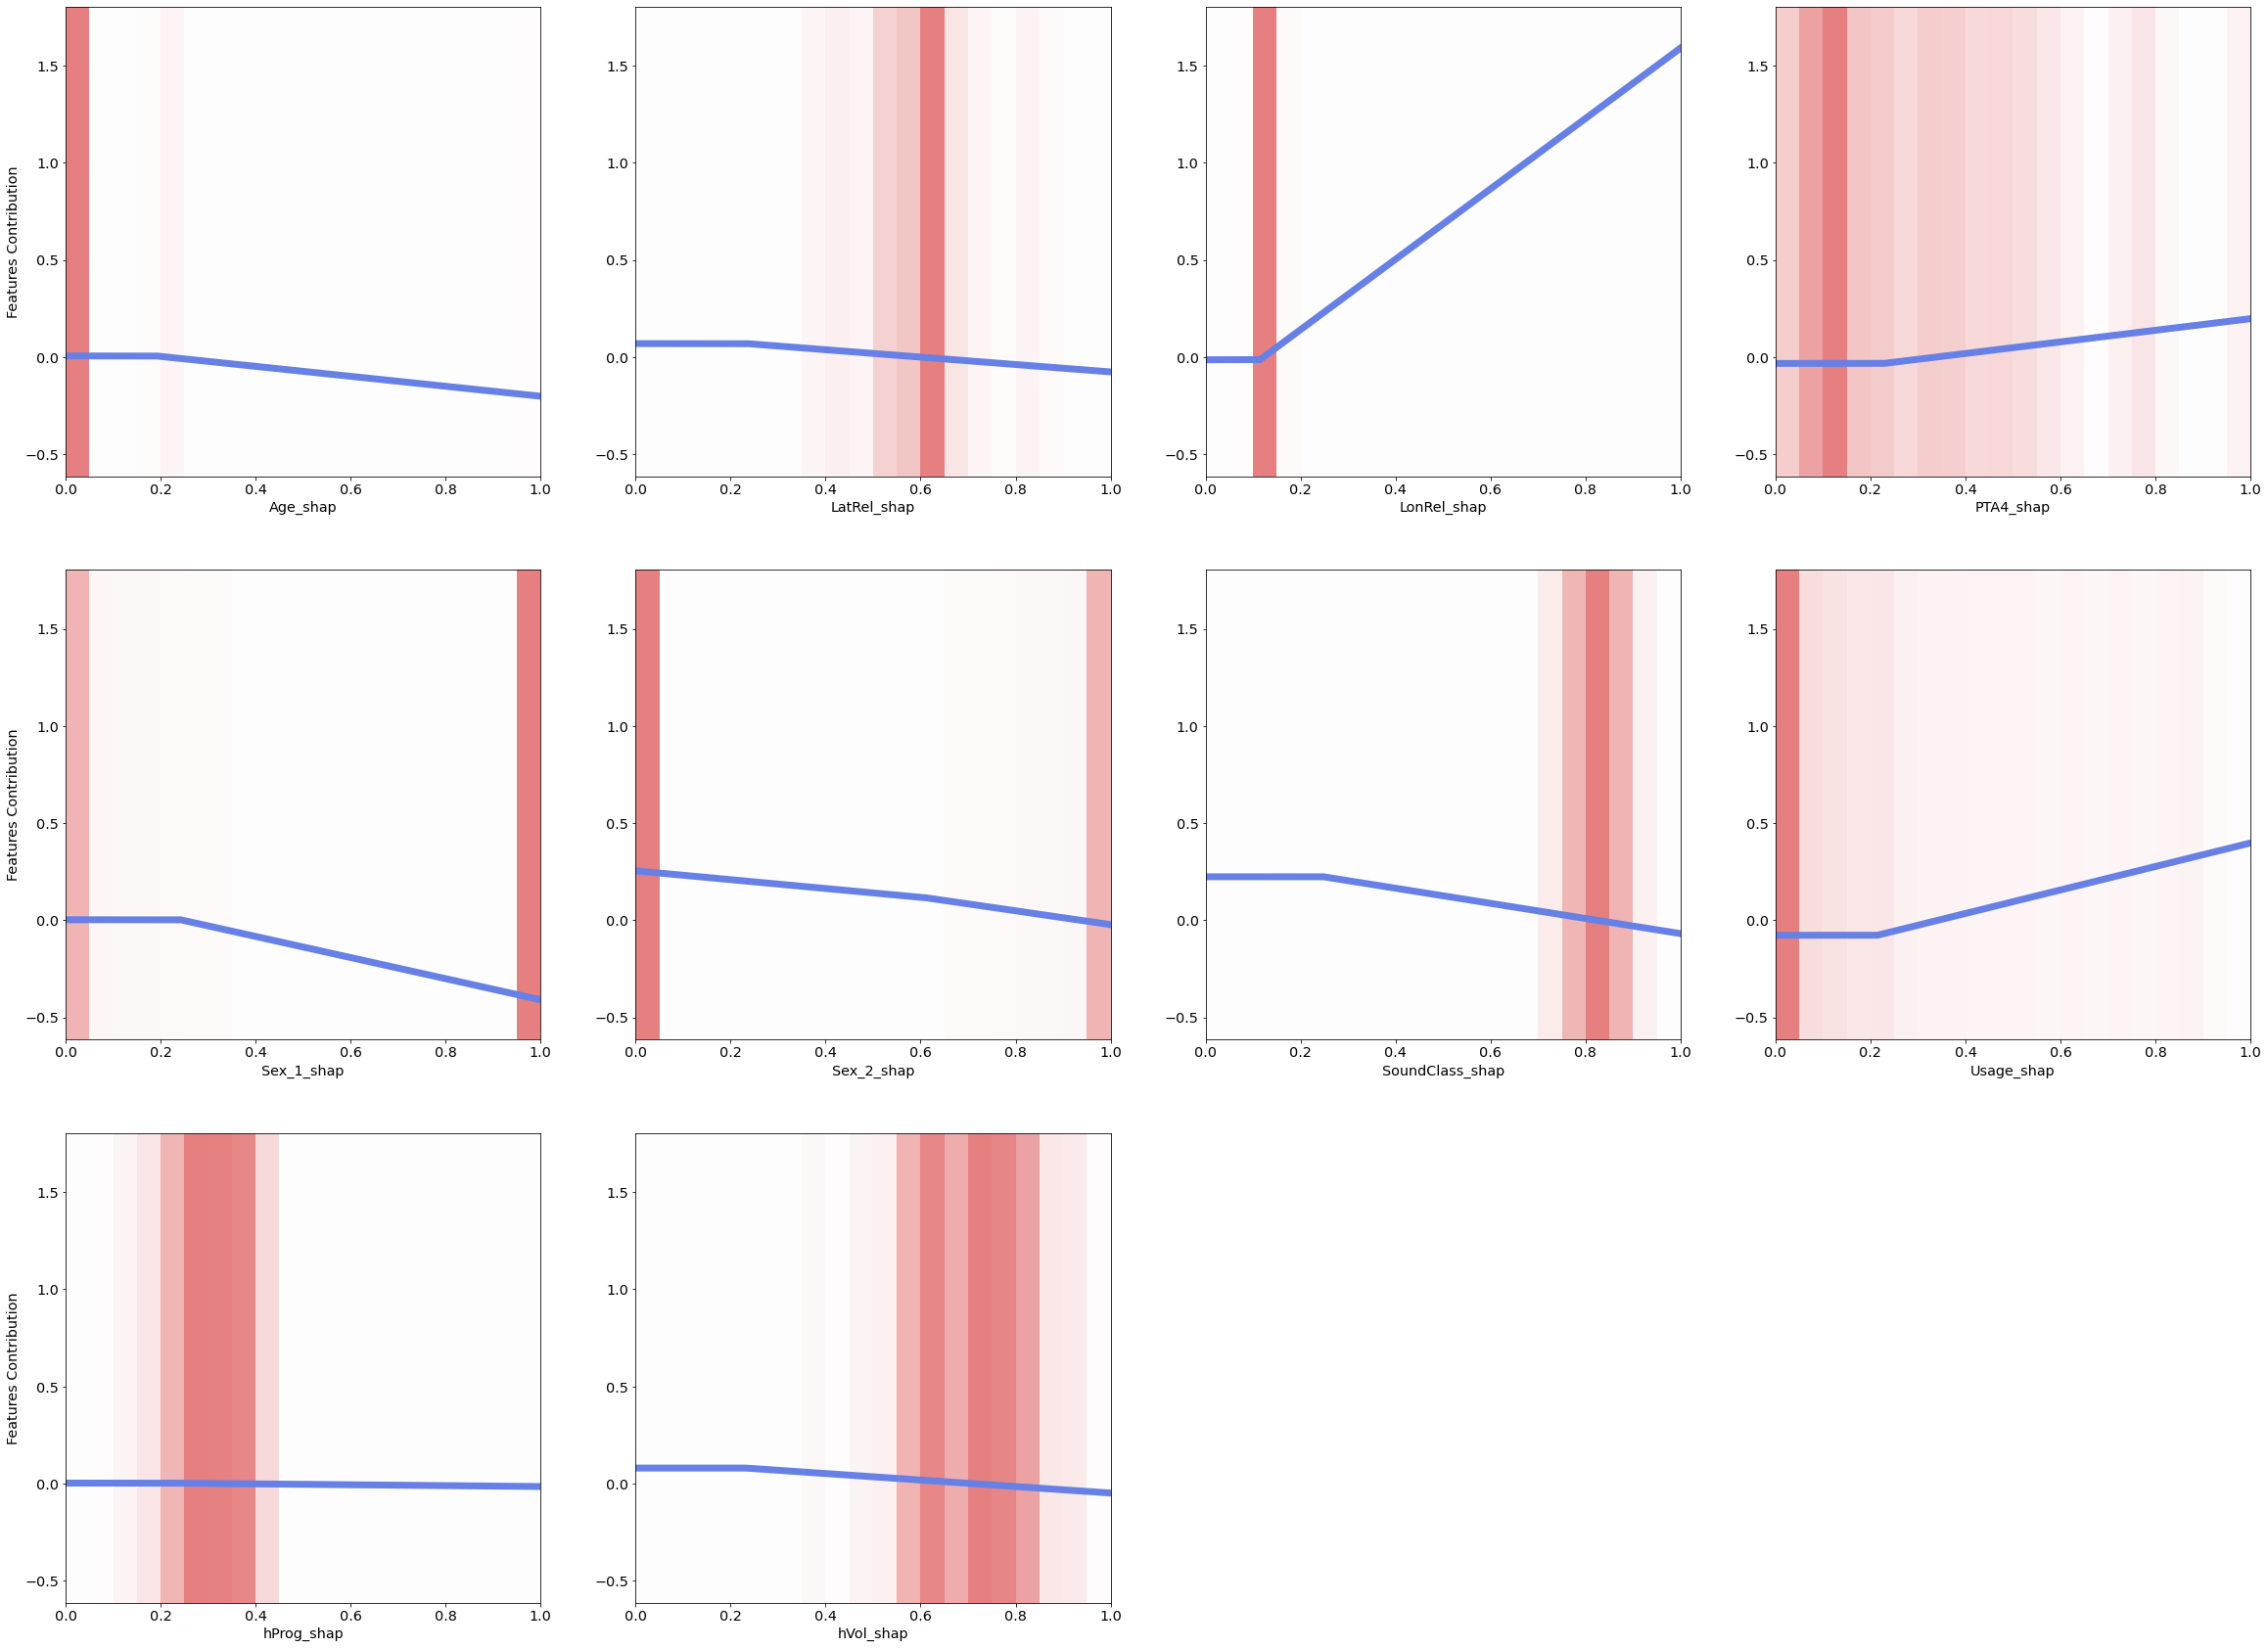

In [ ]:
SHAP_EvoSynth.visualisation()